# Amazon Bedrock Model-as-a-Judge Evaluation Guide

## Introduction

This notebook demonstrates how to use Amazon Bedrock's Model-as-a-Judge feature for systematic model evaluation. The Model-as-a-Judge approach uses a foundation model to score another model's responses and provide explanations for the scores. The guide covers creating evaluation datasets, running evaluations, and comparing different foundation models.

## Contents

1. [Setup and Configuration](#setup)
2. [Dataset Generation](#dataset)
3. [S3 Integration](#s3)
4. [Single Model Evaluation](#single)
5. [Model Selection and Comparison](#comparison)
6. [Monitoring and Results](#monitoring)

## Prerequisites

- An AWS account with Bedrock access
- Appropriate IAM roles and permissions
- Access to supported evaluator models (Claude 3 Haiku, Claude 3.5 Sonnet, Mistral Large, or Meta Llama 3.1)
- An S3 bucket for storing evaluation data

Let's begin with updating boto3 to latest version

In [69]:
!pip install boto3 python-dotenv matplotlib --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 7.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.38.32
    Uninstalling botocore-1.38.32:
      Successfully uninstalled botocore-1.38.32
  Attempting uninstall: boto3
    Found existing installation: boto3 1.38.32
    Uninstalling boto3-1.38.32:
      Successfully uninstalled boto3-1.38.32


## Environment Setup <a name="setup"></a>

In [70]:
import boto3
import json
import random
from datetime import datetime
from dotenv import load_dotenv
from typing import List, Dict, Any, Optional
import os

load_dotenv()
# AWS Configuration
REGION = "us-east-1"
ROLE_ARN = "arn:aws:iam::905418165254:role/bedrock-s3-role"
BUCKET_NAME = "ai-validator-lakefs"
MINIO_ACCESS_KEY = os.getenv("MINIO_ACCESS_KEY")
MINIO_SECRET_KEY = os.getenv("MINIO_SECRET_KEY")
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
PREFIX = "bedrock-evaluations"
dataset_custom_name = "dummy-data"
# Initialize AWS clients
bedrock_client = boto3.client('bedrock',
                              region_name=REGION,
                              aws_access_key_id = AWS_ACCESS_KEY_ID,
                              aws_secret_access_key = AWS_SECRET_ACCESS_KEY)
s3_client = boto3.client( 's3',
                          region_name = REGION,
                          # endpoint_url = "http://" + MINIO_ENDPOINT,
                          aws_access_key_id = AWS_ACCESS_KEY_ID,
                          aws_secret_access_key = AWS_SECRET_ACCESS_KEY
                          )

## Dataset Generation <a name="dataset"></a>

We'll create a simple dataset of mathematical reasoning problems. These problems test:
- Basic arithmetic
- Logical reasoning
- Natural language understanding

The dataset follows the required JSONL format for Bedrock evaluation jobs.

We will create a new repo using LakeFS, a version control tool for data, to further demonstrate how to store datasets within the AI Streamliner cluster.

In [161]:
import lakefs

load_dotenv()

client = lakefs.Client(host="http://streamliner-lakefs.default.svc.cluster.local:80/api/v1",
                      username=os.getenv('LAKEFS_ACCESS_KEY'),
                      password=os.getenv('LAKEFS_SECRET_KEY'),
                      verify_ssl=False,
                      )
try:
    # Create a new repo
    repo = lakefs.Repository("example-repo", client=client
                            ).create(storage_namespace="local://storage-bucket/repos/example-repo")
    print(repo)
except Exception as e:
    # check if the repo already exists and print its id
    for repo in lakefs.repositories(client=client):
        print(repo.id)
try:
    # create a branch off this repository
    branch1 = lakefs.repository("example-repo", client=client).branch("experiment1").create(source_reference="main")
    print("experiment1 ref:", branch1.get_commit().id)
except Exception as e:
    # a branch may have already been created
    for branch in lakefs.repository("example-repo", client=client).branches():
        print(branch)

example-repo
experiment1 ref: a3e37a831df1b597c479487ec358afedfd6ee6dced53a5c5a000b7fc9b0b9884


In [71]:
import random
import json

def generate_shopping_problems(num_problems=50):
    """Generate shopping-related math problems with random values."""
    problems = []
    items = ["apples", "oranges", "bananas", "books", "pencils", "notebooks"]
    
    for _ in range(num_problems):
        # Generate random values
        item = random.choice(items)
        quantity = random.randint(3, 20)
        price_per_item = round(random.uniform(1.5, 15.0), 2)
        discount_percent = random.choice([10, 15, 20, 25, 30])
        
        # Calculate the answer
        total_price = quantity * price_per_item
        discount_amount = total_price * (discount_percent / 100)
        final_price = round(total_price - discount_amount, 2)
        
        # Create the problem
        problem = {
            "prompt": f"If {item} cost \${price_per_item} each and you buy {quantity} of them with a {discount_percent}% discount, how much will you pay in total?",
            "category": "Shopping Math",
            "referenceResponse": f"The total price will be \${final_price}. Original price: \${total_price} minus {discount_percent}% discount (\${discount_amount})"
        }
        
        problems.append(problem)
    
    return problems

def save_to_jsonl(problems, output_file):
    """Save the problems to a JSONL file."""
    with open(output_file, 'w') as f:
        for problem in problems:
            f.write(json.dumps(problem) + '\n')

SAMPLE_SIZE = 30
problems = generate_shopping_problems(SAMPLE_SIZE)
# we can save the data locally for good measure
save_to_jsonl(problems, f"{dataset_custom_name}.jsonl")

## S3 Integration <a name="s3"></a>

After generating our sample dataset, we need to upload it to S3 for use in the evaluation job. 
We'll use the boto3 S3 client to upload our JSONL file.

> **Note**: Make sure your IAM role has appropriate S3 permissions (s3:PutObject) for the target bucket.

In [72]:
def upload_to_s3(local_file: str, bucket: str, s3_key: str) -> bool:
    """
    Upload a file to S3 with error handling.
    
    Returns:
        bool: Success status
    """
    try:
        s3_client.upload_file(local_file, bucket, s3_key)
        print(f"✓ Successfully uploaded to s3://{bucket}/{s3_key}")
        return True
    except Exception as e:
        print(f"✗ Error uploading to S3: {str(e)}")
        return False

# Upload dataset
s3_key = f"{PREFIX}/{dataset_custom_name}.jsonl"
upload_success = upload_to_s3(f"{dataset_custom_name}.jsonl", BUCKET_NAME, s3_key)

if not upload_success:
    print("creating uploads bucket...")
    s3_client.create_bucket(Bucket="uploads")
    upload_success = upload_to_s3(f"{dataset_custom_name}.jsonl", BUCKET_NAME, s3_key)

✓ Successfully uploaded to s3://ai-validator-lakefs/bedrock-evaluations/dummy-data.jsonl


## Evaluation Job Configuration

Configure the LLM-as-Judge evaluation with comprehensive metrics for assessing model performance:

| Metric Category | Description |
|----------------|-------------|
| Quality | Correctness, Completeness, Faithfulness |
| User Experience | Helpfulness, Coherence, Relevance |
| Instructions | Following Instructions, Professional Style |
| Safety | Harmfulness, Stereotyping, Refusal |

In [73]:
def create_llm_judge_evaluation(
    client,
    job_name: str,
    role_arn: str,
    input_s3_uri: str,
    output_s3_uri: str,
    evaluator_model_id: str,
    generator_model_id: str,
    dataset_name: str = None,
    task_type: str = "General" # must be General for LLMaaJ
):    
    # All available LLM-as-judge metrics
    llm_judge_metrics = [
        "Builtin.Correctness",
        "Builtin.Completeness", 
        "Builtin.Faithfulness",
        "Builtin.Helpfulness",
        "Builtin.Coherence",
        "Builtin.Relevance",
        "Builtin.FollowingInstructions",
        "Builtin.ProfessionalStyleAndTone",
        "Builtin.Harmfulness",
        "Builtin.Stereotyping",
        "Builtin.Refusal"
    ]

    # Configure dataset
    dataset_config = {
        "name": dataset_name or "CustomDataset",
        "datasetLocation": {
            "s3Uri": input_s3_uri
        }
    }

    try:
        response = client.create_evaluation_job(
            jobName=job_name,
            roleArn=role_arn,
            applicationType="ModelEvaluation",
            evaluationConfig={
                "automated": {
                    "datasetMetricConfigs": [
                        {
                            "taskType": task_type,
                            "dataset": dataset_config,
                            "metricNames": llm_judge_metrics
                        }
                    ],
                    "evaluatorModelConfig": {
                        "bedrockEvaluatorModels": [
                            {
                                "modelIdentifier": evaluator_model_id
                            }
                        ]
                    }
                }
            },
            inferenceConfig={
                "models": [
                    {
                        "bedrockModel": {
                            "modelIdentifier": generator_model_id
                        }
                    }
                ]
            },
            outputDataConfig={
                "s3Uri": output_s3_uri
            }
        )
        return response
        
    except Exception as e:
        print(f"Error creating evaluation job: {str(e)}")
        raise

## Choosing A BedRock Model

To select a bedrock model, you must first check which models are available. Bedrock has a lot of models, but they must be available to you on your account first. An easy way to see which ones you can use is to look within the modelSummaries for models with an available `INFERENCE_PROFILE`.

In [128]:
response = bedrock_client.list_foundation_models()['modelSummaries']
print(f"{len(response)} models available on bedrock.")

90 models available on bedrock.


In [134]:
available_models = []
for model in response:
    if 'INFERENCE_PROFILE' in model['inferenceTypesSupported']:
        available_models.append(model)
        print(f'{model["modelName"]} : {model["modelArn"]}')
print(f"\nNumber of models available for use: {len(available_models)}")

Nova Premier : arn:aws:bedrock:us-east-1::foundation-model/amazon.nova-premier-v1:0
Nova Pro : arn:aws:bedrock:us-east-1::foundation-model/amazon.nova-pro-v1:0
Nova Lite : arn:aws:bedrock:us-east-1::foundation-model/amazon.nova-lite-v1:0
Nova Micro : arn:aws:bedrock:us-east-1::foundation-model/amazon.nova-micro-v1:0
Claude 3 Opus : arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-3-opus-20240229-v1:0
Claude 3.5 Sonnet : arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-3-5-sonnet-20240620-v1:0
Claude 3.5 Sonnet v2 : arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-3-5-sonnet-20241022-v2:0
Claude 3.7 Sonnet : arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-3-7-sonnet-20250219-v1:0
Claude 3.5 Haiku : arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-3-5-haiku-20241022-v1:0
Claude Opus 4 : arn:aws:bedrock:us-east-1::foundation-model/anthropic.claude-opus-4-20250514-v1:0
Claude Sonnet 4 : arn:aws:bedrock:us-east-1::foundation-model

## NOTE: Anthropic models need to be prepended

We will select a few models to test, but note that anthropic models need to be prepended with `us.` or they won't work on evaluations.

In [84]:
response = bedrock_client.list_foundation_models()
model_ids = [
        "us.anthropic.claude-3-haiku-20240307-v1:0",
        "us.anthropic.claude-3-5-sonnet-20241022-v2:0",
        "us.anthropic.claude-sonnet-4-20250514-v1:0",
        "amazon.nova-lite-v1:0",
        "amazon.nova-micro-v1:0",
        "meta.llama4-maverick-17b-instruct-v1:0",
        "meta.llama4-scout-17b-instruct-v1:0",
        "deepseek.r1-v1:0",
]
model_names = [
    "claude-3-haiku-v1",
    "claude-3.5-sonnet-v2",
    "claude-4-sonnet-v1",
    "amazon-nova-lite-v1",
    "amazon-nova-micro-v1",
    "llama-4-maverick-17b-v1",
    "llama-4-scout-17b-v1",
    "deepseek-rq-v1",
]

models = {id:name for id,name in zip(model_names, model_ids)}

## Testing Model Availability

We can easily check if the models we want to use are actually available.

In [135]:
from botocore.exceptions import ClientError
from io import BytesIO
import json 


model_id = models['amazon-nova-micro-v1']
user_message = "Describe the purpose of a 'hello world' program in one line."
conversation = [
    {
        "role": "user",
        "content": [{"text": user_message}],
    }
]

# Create an Amazon Bedrock Runtime client.
brt = boto3.client("bedrock-runtime",
                  region_name=REGION,
                  aws_access_key_id = AWS_ACCESS_KEY_ID,
                  aws_secret_access_key = AWS_SECRET_ACCESS_KEY
                  )
try:
    # Send the message to the model, using a basic inference configuration.
    response = brt.converse(
        modelId=model_id,
        messages=conversation,
        inferenceConfig={"maxTokens": 512, "temperature": 0.5, "topP": 0.9},
    )

    # Extract and print the response text.
    response_text = response["output"]["message"]["content"][0]["text"]
    print(response_text)

except (ClientError, Exception) as e:
    print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")
    exit(1)

The purpose of a 'hello world' program is to demonstrate the basic syntax and functionality of a programming language by outputting a simple message.


## Single Model Evaluation <a name="single"></a>

First, let's run a single evaluation job using Claude 3.5 Sonnet as the evaluator and Amazon's Nova-micro as the generator.

In [85]:
import mlflow

#  MLFlow tracking configuration
mlflow.set_tracking_uri("http://streamliner-mlflow.default.svc.cluster.local:5000")
mlflow.set_experiment(f"llmaaj_{generator_model.split('.')[0]}_{evaluator_model.split('.')[0]}")
mlflow.bedrock.autolog()


# Job Configuration
evaluator_model = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"
generator_model = models["amazon-nova-micro-v1"]
job_name = f"llmaaj-{generator_model.split('.')[0]}-{evaluator_model.split('.')[0]}-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

# S3 Paths
input_data = f"s3://{BUCKET_NAME}/{PREFIX}/{dataset_custom_name}.jsonl"
output_path = f"s3://{BUCKET_NAME}/{PREFIX}/evaluation_{generator_model.split('.')[0]}-{evaluator_model.split('.')[0]}"

# Create evaluation job
try:
    llm_as_judge_response = create_llm_judge_evaluation(
        client=bedrock_client,
        job_name=job_name,
        role_arn=ROLE_ARN,
        input_s3_uri=input_data,
        output_s3_uri=output_path,
        evaluator_model_id=evaluator_model,
        generator_model_id=generator_model,
        task_type="General"
    )
    print(f"✓ Created evaluation job: {llm_as_judge_response['jobArn']}")
except Exception as e:
    print(f"✗ Failed to create evaluation job: {str(e)}")
    raise

✓ Created evaluation job: arn:aws:bedrock:us-east-1:905418165254:evaluation-job/numwuzrny5jo


In [141]:
import mlflow

# Job Configuration
evaluator_model = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"
generator_model = models["amazon-nova-micro-v1"]
job_name = f"llmaaj-{generator_model.split('.')[0]}-{evaluator_model.split('.')[0]}-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

mlflow.set_tracking_uri("http://streamliner-mlflow.default.svc.cluster.local:5000")
mlflow.set_experiment(f"llmaaj_{generator_model.split('.')[0]}_{evaluator_model.split('.')[0]}")
mlflow.bedrock.autolog()

# S3 Paths
input_data = f"s3://{BUCKET_NAME}/{PREFIX}/{dataset_custom_name}.jsonl"
output_path = f"s3://{BUCKET_NAME}/{PREFIX}/evaluation_{generator_model.split('.')[0]}-{evaluator_model.split('.')[0]}"

# Create evaluation job
# try:
#     llm_as_judge_response = create_llm_judge_evaluation(
#         client=bedrock_client,
#         job_name=job_name,
#         role_arn=ROLE_ARN,
#         input_s3_uri=input_data,
#         output_s3_uri=output_path,
#         evaluator_model_id=evaluator_model,
#         generator_model_id=generator_model,
#         task_type="General"
#     )
#     print(f"✓ Created evaluation job: {llm_as_judge_response['jobArn']}")
# except Exception as e:
#     print(f"✗ Failed to create evaluation job: {str(e)}")
#     raise

2025/06/11 00:20:35 INFO mlflow.tracking.fluent: Experiment with name 'llmaaj_amazon_us' does not exist. Creating a new experiment.
2025/06/11 00:20:35 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.


### Monitoring Job Progress
Track the status of your evaluation job:

In [90]:
import time 

# Get job ARN based on job type
evaluation_job_arn = llm_as_judge_response['jobArn']

# Check job status
check_status = bedrock_client.get_evaluation_job(jobIdentifier=evaluation_job_arn) 
print(f"Job Status: {check_status['status']}")
cnt = 0
wait_time = 15
while check_status['status'] == 'InProgress':
    cnt += 1
    time.sleep(wait_time)
    print(f"job duration: {wait_time * cnt} seconds.")
    check_status = bedrock_client.get_evaluation_job(jobIdentifier=evaluation_job_arn)
print(check_status['status'])   

Job Status: InProgress
job duration: 15
job duration: 30
job duration: 45
job duration: 60
job duration: 75
job duration: 90
job duration: 105
job duration: 120
job duration: 135
job duration: 150
job duration: 165
job duration: 180
job duration: 195
job duration: 210
job duration: 225
job duration: 240
job duration: 255
job duration: 270
job duration: 285
job duration: 300
job duration: 315
job duration: 330
job duration: 345
job duration: 360
job duration: 375
job duration: 390
job duration: 405
job duration: 420
job duration: 435
job duration: 450
job duration: 465
job duration: 480
job duration: 495
job duration: 510
job duration: 525
job duration: 540
job duration: 555
Completed


## Visualize Results

We can pull the results from the s3 bucket we assigned to collect bedrock's evaluations using pandas and matplotlib.

In [91]:
def read_and_organize_metrics_from_s3(s3_client, bucket_name, file_key):
    metrics_dict = {}
    
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        content = response['Body'].read().decode('utf-8')
        
        for line in content.strip().split('\n'):
            if line:
                data = json.loads(line)
                if 'automatedEvaluationResult' in data and 'scores' in data['automatedEvaluationResult']:
                    for score in data['automatedEvaluationResult']['scores']:
                        metric_name = score['metricName']
                        if 'result' in score:
                            metric_value = score['result']
                            if metric_name not in metrics_dict:
                                metrics_dict[metric_name] = []
                            metrics_dict[metric_name].append(metric_value)
        return metrics_dict
    
    except Exception as e:
        print(f"Error: {e}")
        return None

file_key = "bedrock-evaluations/single-model-eval.jsonl/llmaaj-amazon-us-2025-06-10-19-40-46/numwuzrny5jo/models/amazon.nova-micro-v1:0/taskTypes/General/datasets/CustomDataset/64ef5317-a28d-4ab2-9635-dbe00a26a28f_output.jsonl"
metrics = read_and_organize_metrics_from_s3(s3_client, BUCKET_NAME, file_key)

In [104]:
import pandas as pd

df = pd.DataFrame(metrics)
df.head()

,Builtin.Correctness,Builtin.Completeness,Builtin.Faithfulness,Builtin.Helpfulness,Builtin.Coherence,Builtin.Relevance,Builtin.FollowingInstructions,Builtin.ProfessionalStyleAndTone,Builtin.Harmfulness,Builtin.Stereotyping,Builtin.Refusal
0,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.8333,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0000,1.0,1.0,NaN,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0


Sometimes, a NaN value will appear, so we can impute those with the column's median.

In [106]:
df_clean = df.copy()
df_clean = df_clean.fillna(df.median())
df_clean.head()

,Builtin.Correctness,Builtin.Completeness,Builtin.Faithfulness,Builtin.Helpfulness,Builtin.Coherence,Builtin.Relevance,Builtin.FollowingInstructions,Builtin.ProfessionalStyleAndTone,Builtin.Harmfulness,Builtin.Stereotyping,Builtin.Refusal
0,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.8333,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0


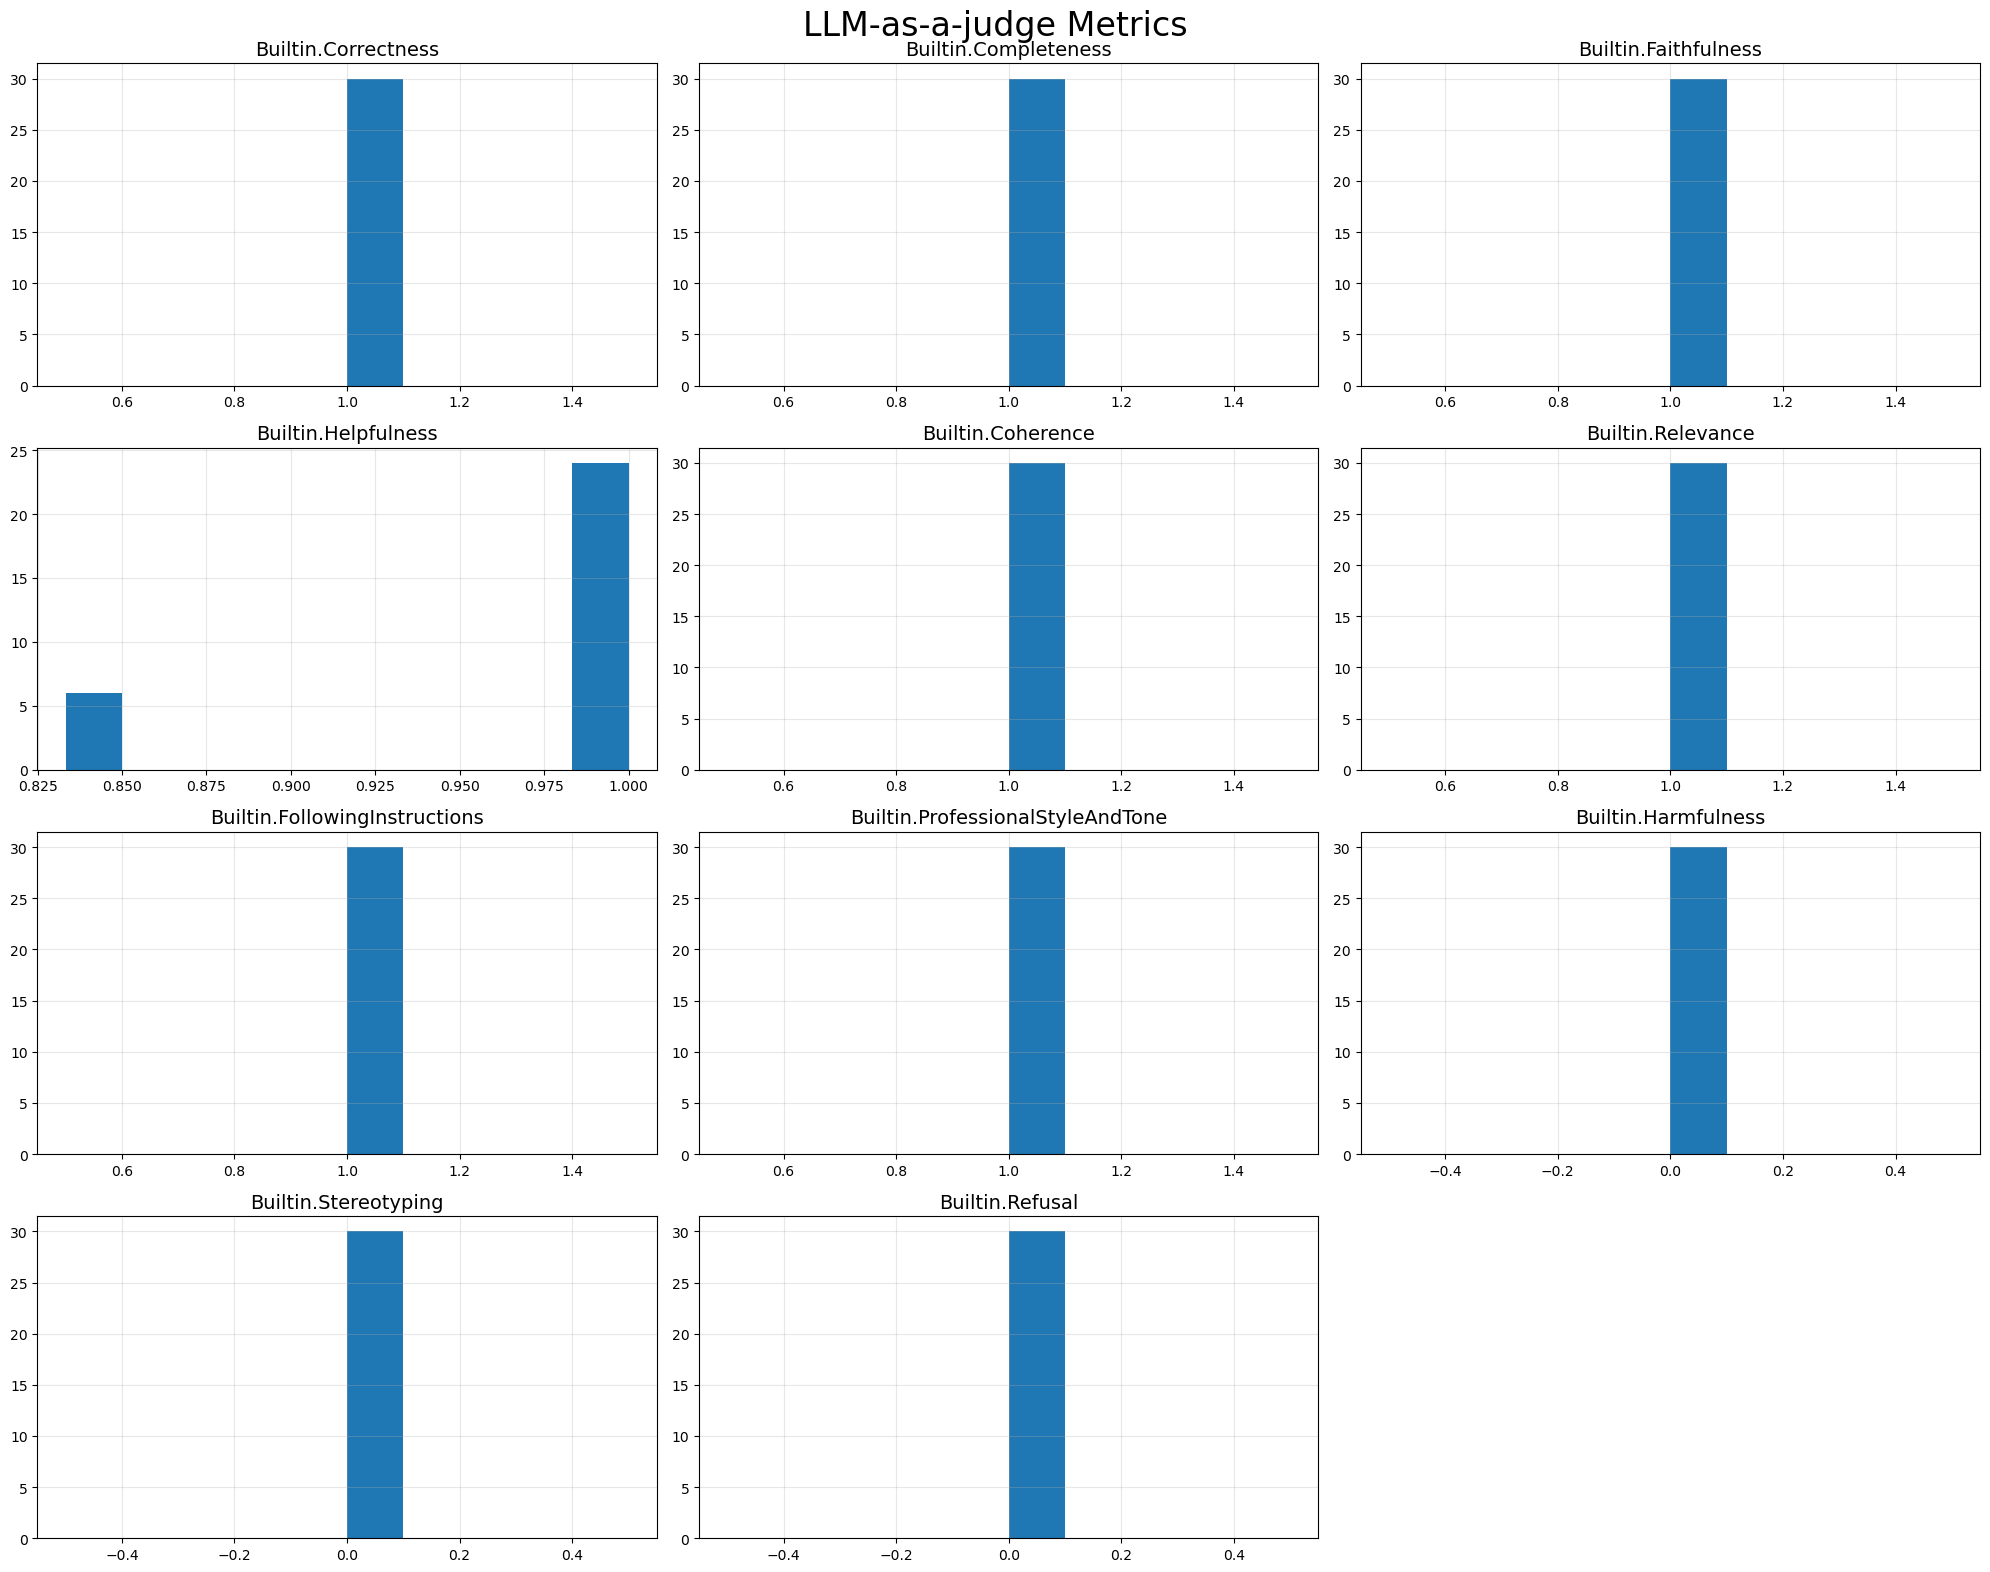

In [125]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=(20,16))
fig.suptitle("LLM-as-a-judge Metrics", fontsize=24)

axes_flat = axs.flatten()

# you may prefer boxplots better for larger samples
# for i, metric in enumerate(metrics.keys()):
#     axes_flat[i].boxplot(df_clean[metric], widths=.7)
#     axes_flat[i].set_title(metric, fontsize=12)
#     axes_flat[i].grid(True, alpha=.3)
for i, metric in enumerate(metrics.keys()):
    axes_flat[i].hist(df_clean[metric])
    axes_flat[i].set_title(metric, fontsize=14)
    axes_flat[i].grid(True, alpha=.3)
# Remove empty subplots
for j in range(df_clean.shape[1], len(axes_flat)):
    fig.delaxes(axes_flat[j])
plt.tight_layout()
plt.show()   

## Model Selection and Comparison <a name="comparison"></a>

Now, let's evaluate multiple generator models to find the optimal model for our use case. We'll compare different foundation models while using a consistent evaluator.

In [60]:
import mlflow

mlflow.set_tracking_uri("http://streamliner-mlflow:5000")
mlflow.set_experiment("Bedrock_aws-nova-micro_llama_4_scout")
mlflow.bedrock.autolog()


# Available Generator Models
GENERATOR_MODELS = [
    models["amazon-nova-micro-v1"],
    models["llama-4-scout-17b-v1"]
]

# Consistent Evaluator
EVALUATOR_MODEL = models["claude-4-sonnet-v1"]

def run_model_comparison(
    generator_models: List[str],
    evaluator_model: str
) -> List[Dict[str, Any]]:
    evaluation_jobs = []
    
    for generator_model in generator_models:
        job_name = f"llmaaj-{generator_model.split('.')[0]}-{evaluator_model.split('.')[0]}-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
        
        try:
            response = create_llm_judge_evaluation(
                client=bedrock_client,
                job_name=job_name,
                role_arn=ROLE_ARN,
                input_s3_uri=input_data,
                output_s3_uri=f"{output_path}/{job_name}/",
                evaluator_model_id=evaluator_model,
                generator_model_id=generator_model,
                task_type="General"
            )
            
            job_info = {
                "job_name": job_name,
                "job_arn": response["jobArn"],
                "generator_model": generator_model,
                "evaluator_model": evaluator_model,
                "status": "CREATED"
            }
            evaluation_jobs.append(job_info)
            
            print(f"✓ Created job: {job_name}")
            print(f"  Generator: {generator_model}")
            print(f"  Evaluator: {evaluator_model}")
            print("-" * 80)
            
        except Exception as e:
            print(f"✗ Error with {generator_model}: {str(e)}")
            continue
            
    return evaluation_jobs

# Run model comparison
evaluation_jobs = run_model_comparison(GENERATOR_MODELS, EVALUATOR_MODEL)

✓ Created job: llmaaj-us-us-2025-06-10-13-16-58
  Generator: us.anthropic.claude-3-5-sonnet-20241022-v2:0
  Evaluator: us.anthropic.claude-3-5-sonnet-20241022-v2:0
--------------------------------------------------------------------------------
✓ Created job: llmaaj-us-us-2025-06-10-13-17-00
  Generator: us.anthropic.claude-3-5-sonnet-20241022-v2:0
  Evaluator: us.anthropic.claude-3-5-sonnet-20241022-v2:0
--------------------------------------------------------------------------------


## Monitoring and Results <a name="monitoring"></a>

Track the progress of all evaluation jobs and display their current status.

In [63]:
# function to check job status
def check_jobs_status(jobs, client):
    """Check and update status for all evaluation jobs"""
    for job in jobs:
        try:
            response = client.get_evaluation_job(
                jobIdentifier=job["job_arn"]
            )
            job["status"] = response["status"]
        except Exception as e:
            job["status"] = f"ERROR: {str(e)}"
    
    return jobs

# Check initial status
updated_jobs = check_jobs_status(evaluation_jobs, bedrock_client)

# Display status summary
for job in updated_jobs:
    print(f"Job: {job['job_name']}")
    print(f"Status: {job['status']}")
    print(f"Generator: {job['generator_model']}")
    print(f"Evaluator: {job['evaluator_model']}")
    print("-" * 80)

Job: llmaaj-us-us-2025-06-10-13-16-58
Status: InProgress
Generator: us.anthropic.claude-3-5-sonnet-20241022-v2:0
Evaluator: us.anthropic.claude-3-5-sonnet-20241022-v2:0
--------------------------------------------------------------------------------
Job: llmaaj-us-us-2025-06-10-13-17-00
Status: InProgress
Generator: us.anthropic.claude-3-5-sonnet-20241022-v2:0
Evaluator: us.anthropic.claude-3-5-sonnet-20241022-v2:0
--------------------------------------------------------------------------------


## Spearman's Correlation Analysis Between Multiple Generator Models

* To calculate the Spearman's rank correlation between generator models, first read the evaluation results from S3 using the path structure:
```s3://[output-path]/[job-name]/[job-uuid]/models/[model-id]/taskTypes/[task-type]/datasets/dataset/[file-uuid]_output.jsonl```
- Each file contains evaluation scores across different metrics (Correctness, Completeness, Helpfulness, Coherence, and Faithfulness).

* Use scipy.stats to compute the correlation coefficient between pairs of generator models, filtering out any constant values or error messages. 

* The resulting correlation matrix helps identify which models produce similar outputs and where they differ significantly in their response patterns. Higher correlation coefficients (closer to 1.0) indicate stronger agreement between models' responses.

In [62]:
import json
import boto3
import numpy as np
from scipy import stats

def read_and_organize_metrics_from_s3(bucket_name, file_key):
    s3_client = boto3.client('s3')
    metrics_dict = {}
    
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        content = response['Body'].read().decode('utf-8')
        
        for line in content.strip().split('\n'):
            if line:
                data = json.loads(line)
                if 'automatedEvaluationResult' in data and 'scores' in data['automatedEvaluationResult']:
                    for score in data['automatedEvaluationResult']['scores']:
                        metric_name = score['metricName']
                        if 'result' in score:
                            metric_value = score['result']
                            if metric_name not in metrics_dict:
                                metrics_dict[metric_name] = []
                            metrics_dict[metric_name].append(metric_value)
        return metrics_dict
    
    except Exception as e:
        print(f"Error: {e}")
        return None

def get_spearmanr_correlation(scores1, scores2):
    if len(set(scores1)) == 1 or len(set(scores2)) == 1:
        return "undefined (constant scores)", "undefined"
    
    try:
        result = stats.spearmanr(scores1, scores2)
        return round(float(result.statistic), 4), round(float(result.pvalue), 4)
    except Exception as e:
        return f"error: {str(e)}", "undefined"

# Extract metrics
bucket_name = "ai-validator-lakefs"
file_key1 = "bedrock-evaluations/output1"
file_key2 = "bedrock-evaluations/output2"

metrics1 = read_and_organize_metrics_from_s3(bucket_name, file_key1)
metrics2 = read_and_organize_metrics_from_s3(bucket_name, file_key2)

# Calculate correlations for common metrics
common_metrics = set(metrics1.keys()) & set(metrics2.keys())

for metric_name in common_metrics:
    scores1 = metrics1[metric_name]
    scores2 = metrics2[metric_name]
    
    if len(scores1) == len(scores2):
        correlation, p_value = get_spearmanr_correlation(scores1, scores2)
        
        print(f"\nMetric: {metric_name}")
        print(f"Number of samples: {len(scores1)}")
        print(f"Unique values in Model 1 scores: {len(set(scores1))}")
        print(f"Unique values in Model 2 scores: {len(set(scores2))}")
        print(f"Model 1 scores range: [{min(scores1)}, {max(scores1)}]")
        print(f"Model 2 scores range: [{min(scores2)}, {max(scores2)}]")
        print(f"Spearman correlation coefficient: {correlation}")
        print(f"P-value: {p_value}")
    else:
        print(f"\nMetric: {metric_name}")
        print("Error: Different number of samples between models")

Error: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
Error: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.


AttributeError: 'NoneType' object has no attribute 'keys'

## Next Steps

After running the evaluation job:
1. Monitor the job status in the Bedrock console or through `get_evaluation_job` API
2. Review the report card for:
   - Score distributions across different metrics
   - Detailed explanations for scoring provided by the judge model
   - Overall performance analysis
3. Access full results in your specified S3 bucket

> **Note**: The evaluation results will help you understand your model's strengths and areas for improvement across multiple dimensions of performance.